In [1]:
class TempClass:
    def __init__(self) -> None:
        self.sigma = 0.15
        self.ratio = 0.7
        self.max_iters = 500
        self.inlier_tol = 2.0

In [2]:
import numpy as np
import cv2

#Import necessary functions

from loadVid import *
from planarH import *
from matchPics import *
import matplotlib.pyplot as plt
from opts import get_opts
opts = TempClass()

In [3]:
# opts = get_opts()
ar_path = '../data/ar_source.mov'
book_path = '../data/book.mov'
cv_book_path = '../data/cv_cover.jpg'

ar_source = loadVid(ar_path)
book = loadVid(book_path)
cv_cover = cv2.imread(cv_book_path)

In [4]:
print('AR_source: ', ar_source.shape, '\nbook: ', book.shape, '\ncv_book: ', cv_cover.shape)
vid_length = min(ar_source.shape[0], book.shape[0]) # Take the shorter video length
vid_length = 3 # For troubleshooting
black_bar_height = 45
scale = (ar_source.shape[1]-2*black_bar_height)/cv_cover.shape[0]
crop_dimensions = (ar_source.shape[1]-2*black_bar_height, int(cv_cover.shape[1]*scale))

AR_source:  (511, 360, 640, 3) 
book:  (641, 480, 640, 3) 
cv_book:  (440, 350, 3)


In [5]:
def HorizontalCrop(img, dimensions):
    deltaX = int(0.5*(img.shape[1] - dimensions[1])) # Crop off left and right evenly
    return img[:, deltaX:deltaX+dimensions[1]]

def VerticalCrop(img, dimensions):
    deltaY = int(0.5*(img.shape[0] - dimensions[0])) # Crop off top and bottom evenly
    return img[deltaY:deltaY+dimensions[0], :]

def CropFrame(img, dimensions):
    img = HorizontalCrop(img, dimensions)
    img = VerticalCrop(img, dimensions)
    return img

In [6]:
final_frames = book.copy()
for i in range(1):
    i = 385
    dest_img = final_frames[i, :, :, :]
    ar_img = ar_source[i, :, :, :]
    ar_img = CropFrame(ar_img, crop_dimensions)
    matches, locs1, locs2 = matchPics(dest_img, cv_cover, opts)
    
    x1 = locs1[matches[:, 0], :]
    x2 = locs2[matches[:, 1], :]
    H, inliers = computeH_ransac(x1, x2, opts)
    print(f'Frame {i}: \tInliers: {np.sum(inliers)} \tVideo Size: {final_frames.shape}')
    template = cv2.resize(ar_img, (cv_cover.shape[1], cv_cover.shape[0]))

    compositeFrame = compositeH(H, template, dest_img)
    # final_frames[i, :, :, :] = compositeFrame
    dest_image = compositeFrame

Frame 385: 	Inliers: 8 	Video Size: (641, 480, 640, 3)


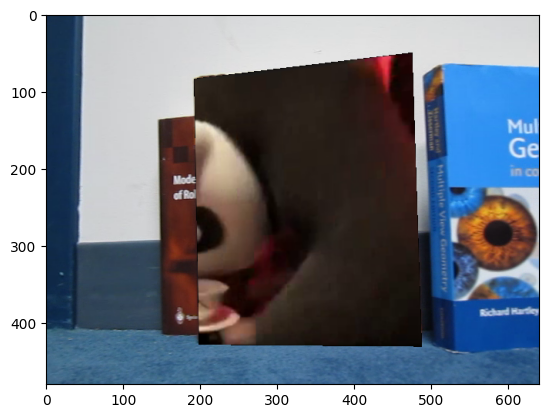

In [9]:
plt.imshow(cv2.cvtColor(final_frames[385, :, :, :], cv2.COLOR_BGR2RGB))

In [ ]:
plt.imshow(cv2.cvtColor(final_frames[385, :, :, :], cv2.COLOR_BGR2RGB))

In [8]:
def MakeVideo(images, save_path, fps):    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    assert(len(images.shape) == 4)
    frameSize = (images.shape[2], images.shape[1])
    video = cv2.VideoWriter(save_path, fourcc, fps, frameSize)
    for img in images:
        video.write(np.uint8(img))
    video.release()
MakeVideo(final_frames, 'test.mp4', fps=30)